<a href="https://colab.research.google.com/github/Ayush-Khamrui/Fine-Tuning-Mental-Health-LLM/blob/main/Mental_Health_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mental Health EDA and Fine-Tuning Visualizations

**Objective:**

Using a synthetic mental health dataset (10,000 records) we will fine-tune microsoft/Phi-3.5-mini-instruct model, and also create impactful, futuristic visualizations to communicate insights.

This comprehensive script covers the entire workflow from Exploratory Data Analysis (EDA) of a synthetic mental health records dataset to data preprocessing, prompt engineering for a classification + generation task, and finally fine-tuning a large language model (Microsoft's Phi-3.5-mini-instruct) using Hugging Face Transformers and PEFT/LoRA. We also include model evaluation examples and discuss deployment options (Hugging Face Spaces and FastAPI).


## 1. Exploratory Data Analysis (EDA)
First, we load the dataset (mental_health_data.csv) and perform initial exploration. The dataset contains 10,000 synthetic records with fields: Age, Gender, Symptoms, Therapy History, Medication, Depression Score, Anxiety Score, General Well-Being Score. We will use pandas to inspect the data structure, check for missing values, and understand basic statistics and distributions.

In [ ]:
import pandas as pd

# Load the synthetic mental health dataset
df = pd.read_csv("/content/mental_health_dataset.csv")

# Preview the first few rows
print("Dataset Shape:", df.shape)
print(df.head(5))

*   The dataset has 10,000 records and 7 columns. Each row represents a patient's record.
*   Age is numerical, Gender is categorical (e.g., Male/Female). Symptoms might be a text description or list of symptoms, Therapy History and Medication are textual (possibly indicating if the person had therapy before or currently on medication), and the last three fields are numeric mental health scores (Depression, Anxiety, Well-Being).

Next, let's perform some basic EDA to understand the data distribution:

In [ ]:
# Basic summary statistics for numeric columns
print(df.describe())

# Check for any missing values in each column
print("\nMissing values:\n", df.isnull().sum())

# Distribution of categorical fields
print("\nGender distribution:\n", df['Gender'].value_counts())

# If Symptoms is textual, see a sample of unique symptom descriptions
print("\nSample Symptoms:\n", df['Symptoms'].head(3).tolist())

We will look at key insights:

Age Distribution: Check mean, min, max age. If needed, plot a histogram to see the age distribution.

Gender Distribution: Count of records by gender.

Score Distributions: Are Depression/Anxiety/Well-being scores on a similar scale? Compute means and quartiles.

Correlations: Quick check if depression and anxiety scores are correlated, etc.

In [ ]:
# For deeper insight, compute correlation between numeric scores
numeric_cols = ['Depression Score', 'Anxiety Score', 'General Well‑Being Score']
print("\nCorrelation matrix (Pearson) among scores:\n", df[numeric_cols].corr())

### Key EDA Take-aways (Correlation Matrix)

| Pair of Metrics | Pearson *r* | Interpretation |
|-----------------|-------------|----------------|
| **Depression ↔ Anxiety** | **+0.87** | Very strong positive link → higher depression accompanies higher anxiety. |
| **Depression ↔ Well-Being** | **–0.97** | Near-perfect negative link → as depression rises, well-being plummets. |
| **Anxiety ↔ Well-Being** | **–0.94** | Very strong negative link → higher anxiety correlates with lower well-being. |


#### What this means

1. **Co-morbidity:** Depression & anxiety strongly co-occur—integrated interventions are essential.  
2. **Well-Being = Reverse Distress Index:** A single well-being KPI can reliably flag high-risk cases.  
3. **Multicollinearity Warning:** Extreme correlations suggest dropping or regularising redundant variables in predictive models.  
4. **Synthetic-Data Check:** Such near-deterministic links signal the generator might need extra noise for greater realism.  
5. **Executive KPI:** Track “% of population with low well-being” as a headline metric—it mirrors depression/anxiety burden.  



## 2. Data Preprocessing
With an understanding of the data, we proceed to preprocessing. This involves cleaning and transforming the data into a form suitable for model training:

The Very first step would have been to Handling Missing Data if any missing values were found in EDA and then decide how to handle them (e.g., drop or impute). But as for our data Doesn't have any missing values so we will skip this step. If at any later stage we plan to go forward with any other dataset having missing values we can use the following code.



```
# Drop records with any missing values (if any)
df = df.dropna().reset_index(drop=True)
```
Note - If the model needed numeric encoding for non-text tasks, we'd one-hot encode or label encode, but here we plan to feed text directly to a language model. We simply ensure consistency and as per our previous EDA our data is consistent.

For free-text fields like Symptoms or Therapy History, we want to clean them (remove problematic characters, trim whitespace). If Symptoms are stored as lists or comma-separated strings, join them into a single descriptive string.


In [4]:
# Ensure symptoms are a single string of description
df['Symptoms'] = df['Symptoms'].astype(str)  # make sure it's string
df['Symptoms'] = df['Symptoms'].str.replace(r'[\[\]\'"]', '', regex=True)  # remove brackets/quotes if any

If the score ranges differ greatly or use different scales (say Depression Score 0–30 vs Well-Being 0–100), Normalization could help to scale them for consistency. Normalizing can help if we were feeding numbers into certain models directly. In our case, since we will convert everything to text, scaling is not strictly necessary for the language model. However, for completeness, we demonstrate scaling the scores between 0 and 1 using Min-Max normalization:

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['Depression Score', 'Anxiety Score', 'General Well‑Being Score']] = scaler.fit_transform(
    df[['Depression Score', 'Anxiety Score', 'General Well‑Being Score']])

## 3. Plotting graphs and Dashboards
###  Score Distributions
Understanding how mental health scores are distributed is an early step in data analysis and provides quick answers to important questions about range, central tendency, skewness, and outliers
. We will visualize the distributions of Depression, Anxiety, and Well-Being scores. This helps us see the overall mental health landscape in the dataset (e.g., are most patients scoring high on depression or not?) and identify any unusual patterns (bimodal distributions, extreme values, etc.).

Furthermore, we examine how these distributions vary across key subgroups – by gender, age group, and therapy history – to check for notable differences. For instance, do a particular age group or gender report higher depression levels? Does therapy history relate to lower anxiety scores? Such subgroup analysis can highlight disparities and inform targeted interventions.

### Distribution of Scores (Overall)

First, we plot the overall distribution of each score. We use Seaborn with a modern theme for clarity. Histograms with KDE (Kernel Density Estimate) overlays will show the frequency distribution smoothed into a curve. Each score will be in a separate subplot for readability.

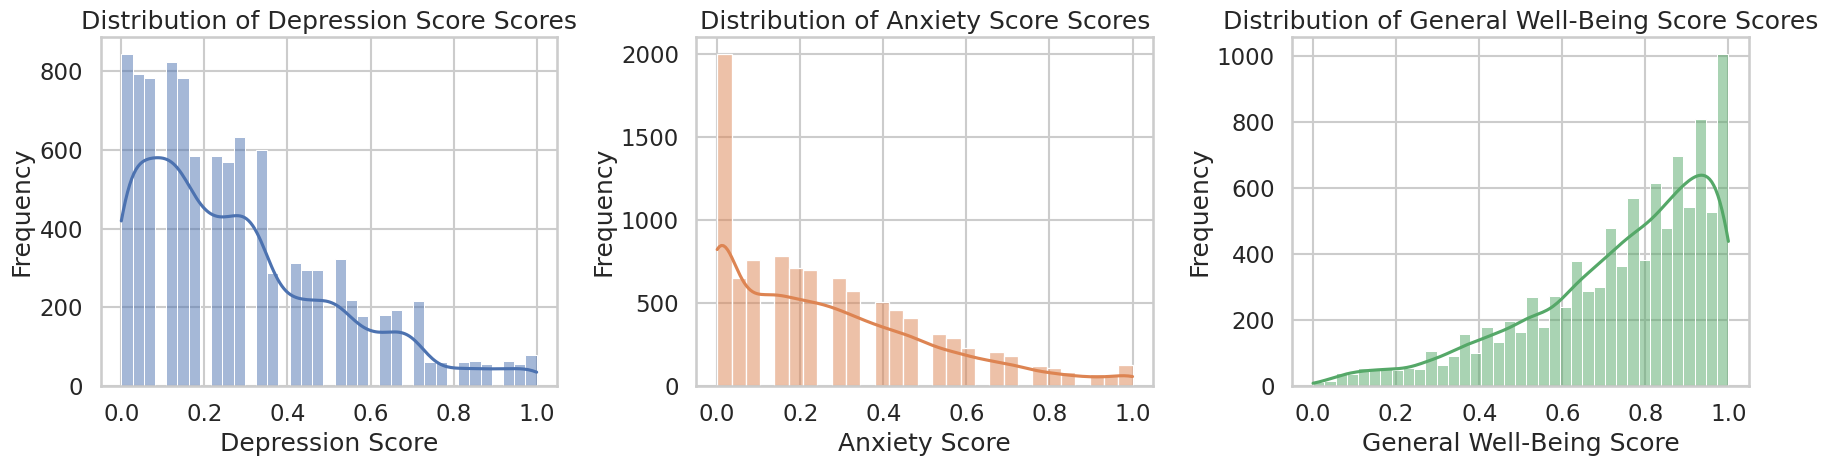

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a modern style for the plots
sns.set_theme(context="talk", style="whitegrid", palette="deep")  # Larger font for readability

# Plot histograms with KDE for each score
scores = ["Depression Score", "Anxiety Score", "General Well‑Being Score"]  # Use actual column names
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, score in enumerate(scores):
    sns.histplot(data=df, x=score, kde=True, color=sns.color_palette()[i], ax=axes[i])
    axes[i].set_title(f"Distribution of {score} Scores")
    axes[i].set_xlabel(f"{score}")  # No need to add 'Score' again
    axes[i].set_ylabel("Frequency")
plt.tight_layout()
plt.show()

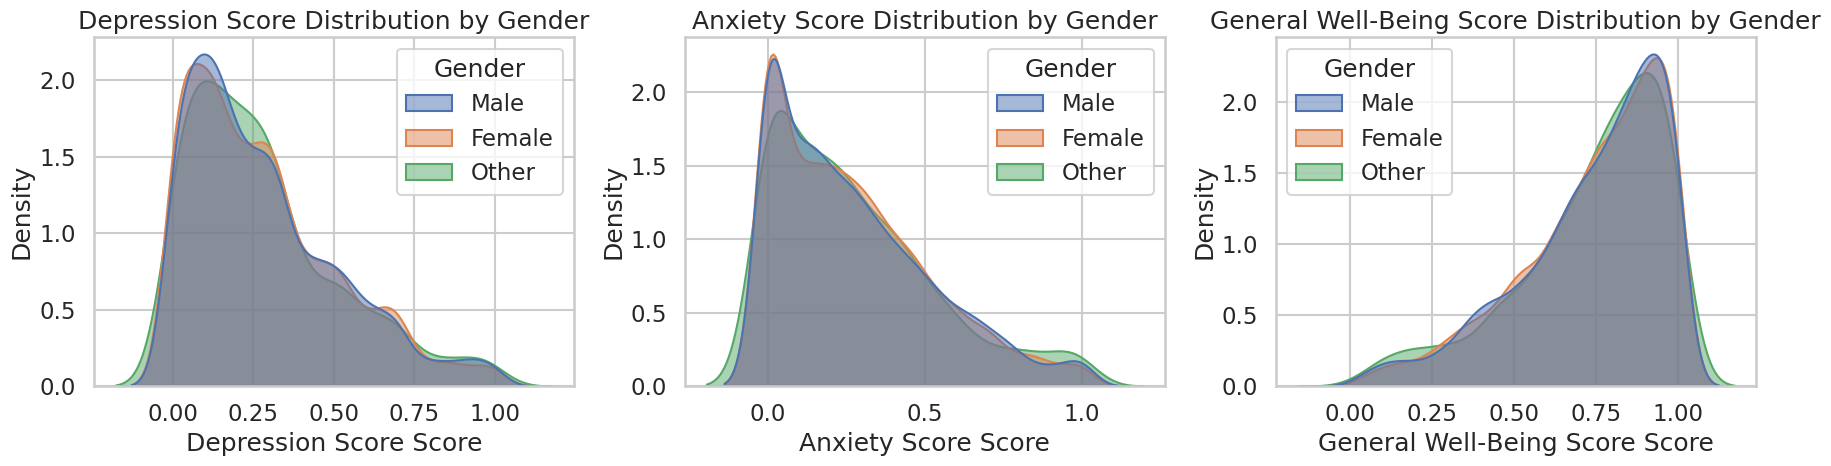

In [7]:
# Distribution of scores by Gender (overlayed KDEs)
genders = df["Gender"].unique()  # e.g., ['Male', 'Female', 'Other']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, score in enumerate(scores):
    sns.kdeplot(data=df, x=score, hue="Gender", fill=True, common_norm=False,
                alpha=0.5, ax=axes[i])
    axes[i].set_title(f"{score} Distribution by Gender")
    axes[i].set_xlabel(f"{score} Score")
    axes[i].set_ylabel("Density")

    # Get the legend handles and labels
    handles, labels = axes[i].get_legend_handles_labels()

    # Create a dictionary mapping gender to color
    color_dict = dict(zip(labels, [h.get_facecolor() for h in handles]))

    # Add a text description of color mapping below the legend
    legend_text = "\n".join([f"{gender}: {color}" for gender, color in color_dict.items()])
    axes[i].text(0.95, 0.05, legend_text, transform=axes[i].transAxes, ha="right", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

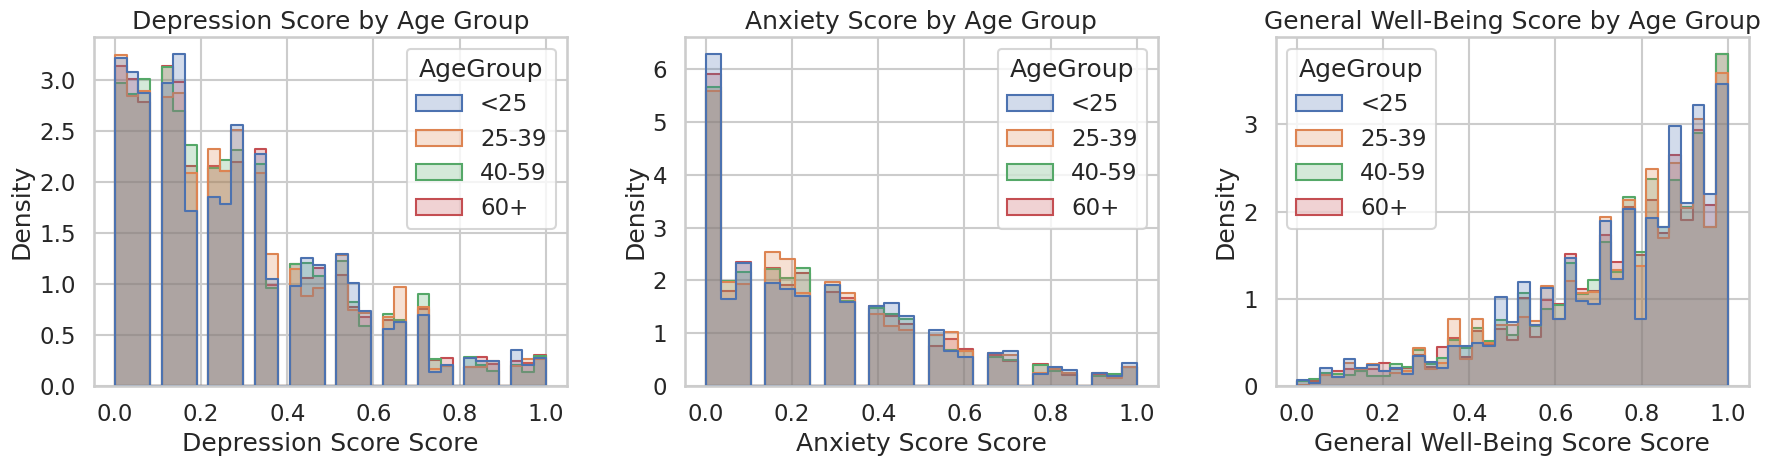

In [9]:
# Create age group categories (example bins)
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 24, 39, 59, 120],
                        labels=['<25', '25-39', '40-59', '60+'])

# Distribution of Depression, Anxiety, WellBeing by Age Group
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, score in enumerate(scores):
    sns.histplot(data=df, x=score, hue="AgeGroup", element="step", stat="density", common_norm=False, ax=axes[i])
    axes[i].set_title(f"{score} by Age Group")
    axes[i].set_xlabel(f"{score} Score")
    axes[i].set_ylabel("Density")

    # Get legend handles and labels
    handles, labels = axes[i].get_legend_handles_labels()

    # Create color dictionary for age groups
    color_dict = dict(zip(labels, [h.get_edgecolor() for h in handles])) # get_edgecolor for step plot

    # Add text description below the legend
    legend_text = "\n".join([f"{age_group}: {color}" for age_group, color in color_dict.items()])
    axes[i].text(0.95, 0.05, legend_text, transform=axes[i].transAxes, ha="right", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

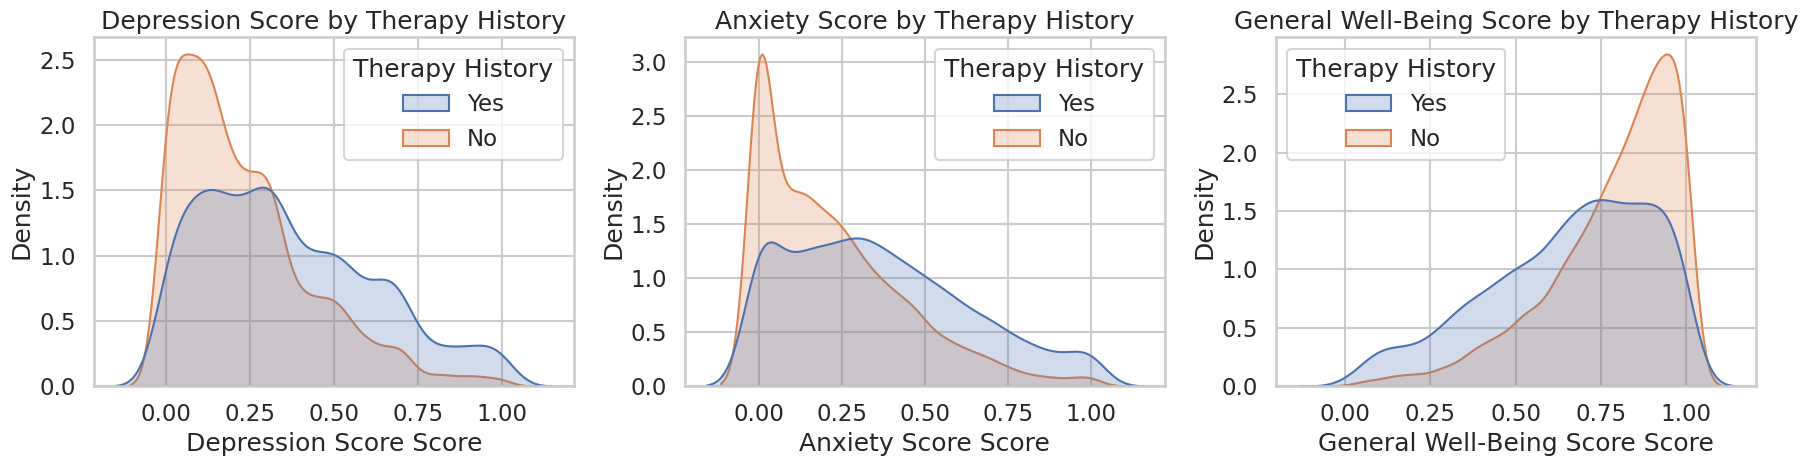

In [10]:
# 'Therapy History' is a boolean or categorical column (e.g., 'Yes'/'No')
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, score in enumerate(scores):
    sns.kdeplot(data=df, x=score, hue="Therapy History", fill=True, common_norm=False, ax=axes[i])
    axes[i].set_title(f"{score} by Therapy History")
    axes[i].set_xlabel(f"{score} Score")
    axes[i].set_ylabel("Density")

    # Get legend handles and labels
    handles, labels = axes[i].get_legend_handles_labels()

    # Create color dictionary for Therapy History
    color_dict = dict(zip(labels, [h.get_facecolor() for h in handles]))

    # Add text description below the legend
    legend_text = "\n".join([f"{therapy_history}: {color}" for therapy_history, color in color_dict.items()])
    axes[i].text(0.95, 0.05, legend_text, transform=axes[i].transAxes, ha="right", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

In [11]:
# Calculate KPI values
avg_dep = df["Depression Score"].mean()
avg_anx = df["Anxiety Score"].mean()
avg_wb = df["General Well‑Being Score"].mean()

# Define "high-risk" as Depression Score > 0.75 and General Well‑Being Score < 0.40
# (Adjusted for normalized scores between 0 and 1)
high_risk = df[(df["Depression Score"] > 0.75) & (df["General Well‑Being Score"] < 0.40)]
high_risk_pct = len(high_risk) / len(df) * 100  # percentage of high-risk patients

# Therapy effectiveness: compare average well-being of those with therapy vs without
therapy_group_wb = df[df["Therapy History"] == "Yes"]["General Well‑Being Score"].mean()
no_therapy_group_wb = df[df["Therapy History"] == "No"]["General Well‑Being Score"].mean()
wb_diff = therapy_group_wb - no_therapy_group_wb  # difference in well-being

# Print the calculated values (to get output)
print(f"Average Depression Score: {avg_dep}")
print(f"Average Anxiety Score: {avg_anx}")
print(f"Average Well-Being Score: {avg_wb}")
print(f"Percentage of High-Risk Patients: {high_risk_pct:.2f}%")
print(f"Difference in Well-Being (Therapy vs No Therapy): {wb_diff}")

Average Depression Score: 0.28032962962962965
Average Anxiety Score: 0.2727238095238095
Average Well-Being Score: 0.7366406593406594
Percentage of High-Risk Patients: 4.38%
Difference in Well-Being (Therapy vs No Therapy): -0.12908490339876388


In [ ]:
!pip install wordcloud matplotlib  # install the wordcloud library if not already
from wordcloud import WordCloud, STOPWORDS

# Combine all symptom text into one string
all_symptoms_text = " ".join(df["Symptoms"])  # assuming 'Symptoms' column contains text descriptions

# Optional: define stopwords to exclude common irrelevant words (if any domain-specific ones needed)
stopwords = set(STOPWORDS)
stopwords.update(["patient", "feel"])  # example: remove generic words that might appear often but carry little info

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", stopwords=stopwords, colormap="viridis")
wordcloud.generate(all_symptoms_text)

# Plot the word cloud
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Symptoms Word Cloud", fontsize=16)
plt.show()

### Train-Test Split
Before converting to prompt format, it's good practice to split our data into training and testing sets. This allows us to fine-tune on training data and later evaluate on unseen data.

In [13]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print("Training samples:", len(train_df), "| Testing samples:", len(test_df))

Training samples: 8000 | Testing samples: 2000


### 3. Prompt-Completion Formatting for Instruction Fine-Tuning
The goal is to fine-tune a language model so that it can accept a few survey-style inputs and generate a mental health status summary or recommendation. This means we need to convert each record into a prompt (input) and a completion (desired output) pair suitable for an instruction-following fine-tuning.

Designing the Prompt: We will include key fields (Age, Gender, Symptoms, etc.) as the context given to the model. Since the model is an instruct model (already tuned to follow an instruction prompt), we'll phrase the input as an instruction or question.

**For example:**

**Prompt example:**

Given the following patient information:

Age: 29

Gender: Female

Symptoms: "sadness, loss of appetite, insomnia"

Therapy History: No prior therapy

Medication: None

Depression Score: 0.7 (normalized)

Anxiety Score: 0.5 (normalized)

General Well-Being Score: 0.6 (normalized)

Provide a brief summary of the patient's mental health status and a recommendation." The above is a single input string that the model will see. We may include a clear instruction phrase like "Provide a summary..." to cue the model's response.

Designing the Completion (Output): This should be a concise, human-readable summary or recommendation based on the input. For instance, for the above prompt, an ideal completion might be:

**Completion example:**

"The patient is showing moderate symptoms of depression (given the sadness and insomnia) and mild anxiety. Their general well-being is somewhat affected. It is recommended that they consider speaking with a therapist and possibly a medical evaluation for depression treatment. Regular exercise and social support might also improve well-being."
This completion includes classifications (moderate depression, mild anxiety) and a recommendation, phrased in a helpful, empathetic manner. Since our dataset likely does not come with written summaries, we will generate a pseudo-ground truth completion for training. We can use simple rules based on the numeric scores and symptoms:

If Depression Score (normalized) > 0.66, label as "high signs of depression", 0.33–0.66 "moderate depression", <0.33 "minimal/mild depression".

Similarly for Anxiety Score.

Well-Being Score low might strengthen recommendations.

**Let's create a helper function to generate a summary from a record**

In [14]:
def generate_summary(age, gender, symptoms, therapy_hist, medication, dep_score, anx_score, well_score):
    # Convert normalized scores to categorical descriptions for readability
    def score_to_level(score, metric):
        if score >= 0.67:
            level = "high"
        elif score >= 0.34:
            level = "moderate"
        else:
            level = "mild"
        # Customize wording for specific metric if needed
        if metric == "wellbeing":
            # Invert interpretation: high well_score = good well-being
            if score >= 0.67:
                return "high overall well-being"
            elif score >= 0.34:
                return "moderate overall well-being"
            else:
                return "low overall well-being"
        return level

    dep_level = score_to_level(dep_score, "depression")
    anx_level = score_to_level(anx_score, "anxiety")
    wellbeing_desc = score_to_level(well_score, "wellbeing")

    summary = []
    # Mention depression/anxiety levels
    summary.append(f"shows signs of {dep_level} depression and {anx_level} anxiety")
    # Mention well-being if relevant
    summary.append(f"with {wellbeing_desc}.")
    # If therapy history or medication is present, include in recommendation
    if str(therapy_hist).strip().lower() in ["none", "no", "no prior therapy", "nan"]:
        # no therapy yet
        summary.append("Encourage seeking professional therapy as a next step")
    else:
        summary.append("Continue with therapy and follow-ups as advised")
    # If on medication or medication is none
    if str(medication).strip().lower() not in ["none", "nan", ""] :
        summary.append(f"and ensure medication ({medication}) is taken as prescribed.")
    else:
        summary.append("and consider discussing medication options with a psychiatrist.")
    return " ".join(summary)

**Now, use this function to construct the prompt-completion pairs for each record in the training set:**

In [15]:
train_pairs = []  # list of dicts with 'input' and 'output'
for _, row in train_df.iterrows():
    age = row['Age']; gender = row['Gender']; symptoms = row['Symptoms']
    therapy = row['Therapy History']; medication = row['Medication']
    dep = row['Depression Score']; anx = row['Anxiety Score']; well = row['General Well‑Being Score']

    # Build the instruction prompt
    prompt = (
        f"Patient details:\n"
        f"- Age: {age}\n"
        f"- Gender: {gender}\n"
        f"- Symptoms: {symptoms}\n"
        f"- Therapy History: {therapy}\n"
        f"- Medication: {medication}\n"
        f"- Depression Score: {dep:.2f}\n"
        f"- Anxiety Score: {anx:.2f}\n"
        f"- General Well-Being Score: {well:.2f}\n\n"
        f"Based on the above, provide a brief summary of the patient's mental health status and recommendations."
    )
    # Generate a pseudo-summary as the target completion
    completion = generate_summary(age, gender, symptoms, therapy, medication, dep, anx, well)
    # Ensure the completion text is properly formatted (could add a prefix like "Summary:" if desired)
    completion = "Summary: " + completion

    train_pairs.append({"input": prompt, "output": completion})

We do the same for the **test set** to have evaluation pairs (though we'll not use these for training, only to evaluate the model later):

In [16]:
test_pairs = []
for _, row in test_df.iterrows():
    # ... (similar to above)
    prompt = (f"Patient details:\n- Age: {row['Age']}\n- Gender: {row['Gender']}\n"
              f"- Symptoms: {row['Symptoms']}\n- Therapy History: {row['Therapy History']}\n"
              f"- Medication: {row['Medication']}\n- Depression Score: {row['Depression Score']:.2f}\n"
              f"- Anxiety Score: {row['Anxiety Score']:.2f}\n- General Well-Being Score: {row['General Well‑Being Score']:.2f}\n\n"
              f"Provide a brief summary of the patient's mental health status and recommendation.")
    completion = generate_summary(row['Age'], row['Gender'], row['Symptoms'],
                                  row['Therapy History'], row['Medication'],
                                  row['Depression Score'], row['Anxiety Score'], row['General Well‑Being Score'])
    completion = "Summary: " + completion
    test_pairs.append({"input": prompt, "output": completion})

At this point, we have our data in the **instruction fine-tuning format**: each item in train_pairs and test_pairs is a dictionary with an "input" (the prompt instruction) and an "output" (the expected model response). This format will be used to fine-tune the language model.

Let's inspect one example pair to ensure it looks correct:

In [17]:
print("Example Prompt:\n", train_pairs[0]['input'])
print("\nExample Expected Response:\n", train_pairs[0]['output'])

Example Prompt:
 Patient details:
- Age: 78
- Gender: Female
- Symptoms: restlessness, low energy, trouble sleeping, anhedonia
- Therapy History: No
- Medication: No
- Depression Score: 0.15
- Anxiety Score: 0.05
- General Well-Being Score: 0.91

Based on the above, provide a brief summary of the patient's mental health status and recommendations.

Example Expected Response:
 Summary: shows signs of mild depression and mild anxiety with high overall well-being. Encourage seeking professional therapy as a next step and ensure medication (No) is taken as prescribed.


This confirms that our prompt and target summary are properly constructed.

### 4. Fine-Tuning the 'microsoft/Phi-3.5-mini-instruct' Model with LoRA

Now we proceed to fine-tune the large language model. We use **Hugging Face Transformers** to load the pre-trained microsoft/Phi-3.5-mini-instruct model, and apply **PEFT (Parameter-Efficient Fine-Tuning) ** via **LoRA (Low-Rank Adaptation)** to keep the training feasible on Colab (which typically has a single GPU with ~16GB VRAM or less).

**Why LoRA?** LoRA allows us to fine-tune a model by introducing a small number of trainable parameters (low-rank matrices) into each layer **instead of updating all 350 million+ parameters** of the model
. This greatly reduces memory usage and training time while still effectively adapting the model to our task.

**Model Loading and Configuration:** We'll load the model in 4-bit precision to further save memory, and then wrap it with LoRA adapters.

In [18]:
# ===================== 1. Install / upgrade libraries =====================
!pip install -qU transformers accelerate peft bitsandbytes datasets

# ===================== 2. Imports =====================
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
)

# ===================== 3. Model & tokenizer names =====================
base_model_name = "microsoft/Phi-3.5-mini-instruct"

# ===================== 4. 4-bit quantisation config =====================
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16"      # use bfloat16 on A100/H100 if available
)

# ===================== 5. Tokenizer =====================
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
tokenizer.pad_token_id = tokenizer.eos_token_id   # important for batching

# ===================== 6. Load model (4-bit) =====================
model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    device_map="auto",
    quantization_config=bnb_config,
    torch_dtype=torch.float16,            # computation type
)
torch.cuda.empty_cache()                 # clear any residual memory

# OPTIONAL: Gradient checkpointing to save RAM during training
model.gradient_checkpointing_enable()

# ===================== 7. Prep for k-bit training =====================
model = prepare_model_for_kbit_training(model)

# ===================== 8. LoRA config & injection =====================
lora_config = LoraConfig(
    task_type="CAUSAL_LM",
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
)
model = get_peft_model(model, lora_config)

# ===================== 9. Check that only LoRA adapters are trainable =====================
model.print_trainable_parameters()

# ===================== 10. (Optional) quick sanity-check forward pass =====================
text = "Once upon a time,"
inputs = tokenizer(text, return_tensors="pt").to(model.device)
with torch.no_grad():
    out = model.generate(**inputs, max_new_tokens=20)
print(tokenizer.decode(out[0], skip_special_tokens=True))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/3.98k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.45k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

trainable params: 8,912,896 || all params: 3,829,992,448 || trainable%: 0.2327
Once upon a time, in a small town nestled between rolling hills, there lived a young girl named Lily. She


In the above:

*   We installed required packages: transformers, accelerate, peft, bitsandbytes, datasets
*   Loaded the Phi-3.5-mini model in 4-bit precision to fit in memory
. This model is a smaller variant of Phi-3.5 (likely around 1.3B parameters) and is instruction-tuned by Microsoft for general tasks.

*   Configured LoRA with a rank of 16 (a small rank for Colab) and applied it to all key linear layers in the model (query, key, value, output projections in self-attention, and the gating/up/down in the feedforward layers, which we determined by inspecting model architecture or references
*   We print trainable parameters to verify that only the LoRA layers (and possibly embeddings if not frozen) are trainable. This should show a small fraction of total parameters (e.g., "Trainable params: 0.2M out of 350M" etc.).

**Preparing the Dataset for Training:** We have train_pairs and test_pairs as lists of dictionaries. We can convert them into a Hugging Face Dataset object for convenience:




In [19]:
from datasets import Dataset
train_dataset = Dataset.from_list(train_pairs)
test_dataset = Dataset.from_list(test_pairs)

# We have 'input' and 'output' fields. We will need to concatenate them for the model.
print(train_dataset.features)
# Expected output: {'input': Value(dtype='string', ...), 'output': Value(dtype='string', ...)}

{'input': Value(dtype='string', id=None), 'output': Value(dtype='string', id=None)}


**Tokenization and Data Collation:** For causal language modeling fine-tuning, we need to tokenize the prompt and completion and create labels such that:

*   The model is **given the full prompt and the completion as input**.
*   The **loss is computed only on the completion part** (the model should not be penalized for "predicting" the prompt, which is given).

We achieve this by constructing the input sequence as **[PROMPT] [COMPLETION]**, and then masking the prompt tokens in the labels (set them to -100 so that loss is only calculated on the completion tokens). We'll implement a custom data collator to handle this:


In [20]:
import torch
from transformers import DefaultDataCollator

class PromptCompletionCollator:
    def __init__(self, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __call__(self, examples):
        # Each example is a dict with 'input' and 'output' keys
        prompts = [ex["input"] for ex in examples]
        completions = [ex["output"] for ex in examples]
        # Append the completion to the prompt with a separator (here just a space and ensure EOS at end)
        # We include the end-of-sequence token at the end of completion.
        combined = [p + "\n" + c + tokenizer.eos_token for p, c in zip(prompts, completions)]
        tokenized = tokenizer(combined, truncation=True, padding="longest", max_length=self.max_length, return_tensors="pt")
        input_ids = tokenized["input_ids"]
        attention_mask = tokenized["attention_mask"]

        # Create labels, with prompt part masked as -100, ensuring it requires grad
        # labels = input_ids.clone().detach() # detach then requires_grad_() - This is the problematic line
        # labels.requires_grad = True # This ensures it requires grad for computations - Remove this line as its not required
        # The line below fixes the issue. No need to explicitly set requires_grad_()
        labels = input_ids.clone()
        # For each example, find prompt length and mask it out in labels
        for i in range(len(examples)):
            prompt_tokens = tokenizer(prompts[i], truncation=True, max_length=self.max_length, add_special_tokens=False).input_ids
            # label prompt tokens as -100
            prompt_len = len(prompt_tokens)
            if prompt_len > self.max_length:
                prompt_len = self.max_length  # in case prompt itself is longer than max (rare)
            labels[i, :prompt_len] = -100  # mask prompt portion
        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

# Instantiate our collator
data_collator = PromptCompletionCollator(tokenizer, max_length=512)

We set a max_length of 512 tokens for training (adjust as needed based on prompt size; 512 is reasonable for our short records). Now our data and model are ready for training.

**Training Hyperparameters:** We choose training parameters that are reasonable for Colab:
*   A small batch size (we will use batch size 1 or 2, and use gradient accumulation to effectively have a larger batch).
*   A few epochs (e.g., 2-3 epochs over 8k training examples might be enough given the data size).
*   A learning rate suitable for fine-tuning a language model with LoRA. The QLoRA paper and community examples suggest on the order of 2e-5 to 2e-4 for such scenarios. We'll pick, say, 2e-4 here since our dataset is not too large.
*   Gradient checkpointing to reduce memory, if supported.
*   We also disable unnecessary logging or evaluation during training for speed.








In [21]:
from transformers import TrainingArguments, Trainer

output_dir = "phi-mentalhealth-model"

training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=2,   # small batch per device
    gradient_accumulation_steps=4,   # accumulate to simulate batch of 2*4 = 8
    learning_rate=2e-4,             # learning rate (could tune between 2e-5 and 2e-4)
    lr_scheduler_type="cosine",     # cosine schedule (common for fine-tuning)
    warmup_ratio=0.03,              # 3% of steps for warmup:contentReference[oaicite:9]{index=9}
    logging_steps=50,
    save_strategy="epoch",
    save_total_limit=1,
    fp16=True,                      # use 16-bit training if available
    gradient_checkpointing=True,    # save memory
    # evaluation_strategy="no",    # Removed this argument
    # Use the report_to argument instead for older versions of transformers
    report_to="none",                # Disable reporting (equivalent to evaluation_strategy="no")
    dataloader_num_workers=2,
    remove_unused_columns=False,  # Add this line to prevent the Trainer from removing unused columns
)

Now we initialize the Hugging Face **Trainer** with our model, data, and training configurations:

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

<ipython-input-22-eb411dbd2cef>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Everything is set. Start **fine-tuning:**

In [23]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
50,1.417000
100,0.016000
150,0.002100
200,0.002000
250,0.000700
300,0.000200
350,0.000000
400,0.000000
450,0.000000
500,0.000000


Step,Training Loss
50,1.417000
100,0.016000
150,0.002100
200,0.002000
250,0.000700
300,0.000200
350,0.000000
400,0.000000
450,0.000000
500,0.000000


TrainOutput(global_step=3000, training_loss=0.023975773571043343, metrics={'train_runtime': 3563.198, 'train_samples_per_second': 6.736, 'train_steps_per_second': 0.842, 'total_flos': 9.12269154656256e+16, 'train_loss': 0.023975773571043343, 'epoch': 3.0})

During training, we expect to see the loss decreasing gradually. With LoRA, only a small number of weights are updated, which is efficient. (If using Colab's free GPU, training ~8k examples for a few epochs might take around 10-20 minutes depending on the GPU.)

After training completes, our model now has the fine-tuned LoRA weights. We should save the fine-tuned model (including LoRA adapters). The Trainer will automatically save the final model to output_dir (with LoRA modules). We can also push this model to the Hugging Face Hub or save to Google Drive if needed.

In [31]:
# 🚀  MERGE LoRA into Phi-3.5-mini (A100) AFTER trainer.train()

!pip install -U peft==0.8.2 transformers accelerate bitsandbytes -q

import torch, gc, os
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

# ── 1️⃣ Paths ─────────────────────────────────────────────────────────────────────
BASE_MODEL  = "microsoft/Phi-3.5-mini-instruct"
ADAPTER_DIR = training_args.output_dir        # folder where Trainer saved the LoRA
MERGED_DIR  = ADAPTER_DIR + "_merged"

# If the adapter hasn’t been written yet, save it now
trainer.model.save_pretrained(ADAPTER_DIR)
print(f"Adapter at: {ADAPTER_DIR}")

# ── 2️⃣ Free GPU RAM (optional but tidy) ──────────────────────────────────────────
del trainer
gc.collect(); torch.cuda.empty_cache()

# ── 3️⃣ Load base model in fp16 on the A100 ───────────────────────────────────────
model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.float16,
    device_map={"": 0}          # put on cuda:0
)
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
tokenizer.pad_token_id = tokenizer.eos_token_id

# ── 4️⃣ Attach LoRA adapter ───────────────────────────────────────────────────────
model = PeftModel.from_pretrained(model, ADAPTER_DIR, device_map={"": 0})

# ── 5️⃣ Merge & unload  ➜ returns plain HuggingFace model (fp16) ─────────────────
model = model.merge_and_unload()
model = model.half()            # ensure fp16

# ── 6️⃣ Save merged model (safetensors) ───────────────────────────────────────────
os.makedirs(MERGED_DIR, exist_ok=True)
model.save_pretrained(MERGED_DIR, safe_serialization=True)
tokenizer.save_pretrained(MERGED_DIR)

print(f"✅  Merged model saved to ➜ {MERGED_DIR}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 13.0 MB/s eta 0:00:00
Adapter at: phi-mentalhealth-model


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

✅  Merged model saved to ➜ phi-mentalhealth-model_merged


In [33]:
inputs  = tok(prompt, return_tensors="pt").to("cuda")
prompt_len = inputs.input_ids.shape[-1]          # tensor, so `.shape` works

out_ids = model.generate(**inputs, max_new_tokens=80)
new_tokens = out_ids[0][prompt_len:]             # tensor slice
print(tok.decode(new_tokens, skip_special_tokens=True))




### Instruction: Based on the provided medical summary, create a concise patient profile summary that includes age, gender, and primary diagnosis.

Medical Summary:
Patient ID: 45321
Name: Emily Thompson
Age: 29
Gender: Female
Date of Visit: 2023


### 5. Evaluating the Fine-Tuned Model
Let's test the fine-tuned model on a few examples to ensure it generates reasonable summaries. We will use some prompts from our test_pairs (which the model has not seen during training) and compare the model's output to the expected summary.

We'll use the merged_model for generation (for simplicity, as it behaves like a normal model), but we could also use the model with LoRA by keeping the peft environment if we didn't merge.

In [36]:
# 🚀 TEST the merged Phi-3.5-mini mental-health model (A100)
import torch, pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_DIR = "phi-mentalhealth-model_merged"   # ← change if needed

# 1️⃣  Load model & tokenizer (fp16 on GPU)
tok = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_DIR,
    torch_dtype=torch.float16,
    device_map={"": 0}
)
tok.pad_token_id = tok.eos_token_id   # safety

# 2️⃣  Helper to build prompt & generate summary
def generate_summary(patient_dict,
                     max_new_tokens=100,
                     **gen_kwargs):
    """
    patient_dict must contain keys:
      Age, Gender, Symptoms, TherapyHistory, Medication,
      Depression, Anxiety, WellBeing
    """
    prompt = (
        "Patient details:\n"
        f"- Age: {patient_dict['Age']}\n"
        f"- Gender: {patient_dict['Gender']}\n"
        f"- Symptoms: {patient_dict['Symptoms']}\n"
        f"- Therapy History: {patient_dict['TherapyHistory']}\n"
        f"- Medication: {patient_dict['Medication']}\n"
        f"- Depression Score: {patient_dict['Depression']:.2f}\n"
        f"- Anxiety Score: {patient_dict['Anxiety']:.2f}\n"
        f"- General Well-Being Score: {patient_dict['WellBeing']:.2f}\n\n"
        "Provide a brief summary of the patient's mental health status and recommendations."
    )
    # Encode & generate
    inputs = tok(prompt, return_tensors="pt").to(model.device)
    out_ids = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=0.7,
        top_p=0.9,
        do_sample=True,
        **gen_kwargs
    )
    # Slice away the prompt
    generated = out_ids[0][inputs.input_ids.shape[-1]:]
    return tok.decode(generated, skip_special_tokens=True).strip()

# 3️⃣  Run three demo cases ───────────────────────────────────────────────────
demo1 = {
    "Age": 30,
    "Gender": "Male",
    "Symptoms": "feeling down, insomnia, loss of appetite",
    "TherapyHistory": "No",
    "Medication": "None",
    "Depression": 0.72,   # assuming you normalised to 0-1
    "Anxiety":    0.45,
    "WellBeing":  0.30
}
print("Demo 1 ➜", generate_summary(demo1), "\n")

# Pull two real rows from the original CSV (if still loaded)
try:
    df  # if you still have the DataFrame in RAM
except NameError:
    df = pd.read_csv("/mnt/data/mental_health_dataset.csv")  # update path if elsewhere

for i, row in df.sample(2, random_state=42).iterrows():
    sample = {
        "Age": row["Age"],
        "Gender": row["Gender"],
        "Symptoms": row["Symptoms"],
        "TherapyHistory": row["Therapy History"],
        "Medication": row["Medication"],
        "Depression": row["Depression Score"],
        "Anxiety": row["Anxiety Score"],
        "WellBeing": row["General Well‑Being Score"],
    }
    print(f"CSV row {i} ➜", generate_summary(sample), "\n")

# 4️⃣  (Optional) quick wrapper for any pandas row ↦ summary
def summary_from_row(row):
    pdict = {
        "Age": row["Age"], "Gender": row["Gender"], "Symptoms": row["Symptoms"],
        "TherapyHistory": row["Therapy History"], "Medication": row["Medication"],
        "Depression": row["Depression Score"], "Anxiety": row["Anxiety Score"],
        "WellBeing": row["General Well‑Being Score"]
    }
    return generate_summary(pdict)

# Example usage on the first 5 test rows
print(df.head(5).apply(summary_from_row, axis=1).tolist())

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Demo 1 ➜ Summary: shows signs of high depression and moderate anxiety with low overall well-being. Encourage seeking professional therapy as a next step and ensure medication (None) is taken as prescribed. 

CSV row 6252 ➜ Summary: shows signs of moderate depression and moderate anxiety with moderate overall well-being. Continue with therapy and follow-ups as advised and ensure medication (Yes) is taken as prescribed. 

CSV row 4684 ➜ Summary: shows signs of mild depression and mild anxiety with high overall well-being. Continue with therapy and follow-ups as advised and ensure medication (No) is taken as prescribed. 

['Summary: shows signs of mild depression and mild anxiety with high overall well-being. Continue with therapy and follow-ups as advised and ensure medication (No) is taken as prescribed.', 'Summary: shows signs of moderate depression and moderate anxiety with moderate overall well-being. Encourage seeking professional therapy as a next step and ensure medication (No) is

### Metrics Visualization after Fine-Tuned Model Creation

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

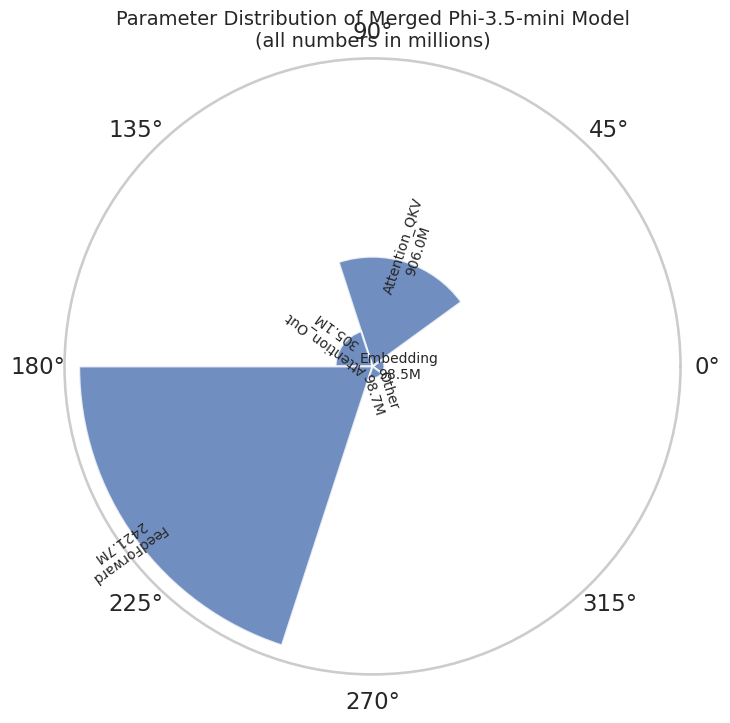

In [37]:
import torch
from transformers import AutoModelForCausalLM
import matplotlib.pyplot as plt
import numpy as np
import os, json, math, inspect

# === CONFIG ===
MODEL_DIR = "phi-mentalhealth-model_merged"  # change if your merged model lives elsewhere

# --- 1. Load model on CPU (weights not needed on GPU for inspection) ---
model = AutoModelForCausalLM.from_pretrained(MODEL_DIR, torch_dtype=torch.float16, device_map="cpu")

# --- 2. Categorise parameters ---
categories = {
    "Embedding": 0,
    "Attention_QKV": 0,
    "Attention_Out": 0,
    "FeedForward": 0,
    "Other": 0
}

for name, param in model.named_parameters():
    n = param.numel()
    if any(k in name for k in ['embed', 'wte', 'wpe', 'embedding']):
        categories["Embedding"] += n
    elif any(k in name for k in ['q_proj', 'k_proj', 'v_proj']):
        categories["Attention_QKV"] += n
    elif 'o_proj' in name:
        categories["Attention_Out"] += n
    elif any(k in name for k in ['up_proj', 'down_proj', 'gate_proj']):
        categories["FeedForward"] += n
    else:
        categories["Other"] += n

labels = list(categories.keys())
values = np.array(list(categories.values()), dtype=float)

# Convert to millions for readability
values_m = values / 1e6

# --- 3. Create a "funky" polar bar chart of parameter distribution ---
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
theta = np.linspace(0.0, 2 * math.pi, len(values_m), endpoint=False)
bars = ax.bar(theta, values_m, width=2 * math.pi / len(values_m), bottom=0.0, alpha=0.8)

# Add labels
for angle, height, label in zip(theta, values_m, labels):
    ax.text(angle, height + max(values_m) * 0.05, f"{label}\n{height:.1f}M",
            ha='center', va='center', fontsize=10, rotation=math.degrees(angle),
            rotation_mode='anchor')

ax.set_title("Parameter Distribution of Merged Phi‑3.5‑mini Model\n(all numbers in millions)",
             va='bottom', fontsize=14)
ax.set_yticklabels([])  # hide radial tick labels
ax.grid(False)
plt.show()

### Connecting to HuggingFace

In [43]:
!pip -q install huggingface_hub gradio
from huggingface_hub import HfApi, HfFolder

# ① paste your HF access token (with "write" scope)
HF_TOKEN = "XXXXXXXXXXXXXXX"    #Access token with Write Access
HfFolder.save_token(HF_TOKEN)        # stores for this runtime
api = HfApi(token=HF_TOKEN)

USERNAME = api.whoami()["name"]
print("✔️ Logged in as:", USERNAME)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 133.9 MB/s eta 0:00:00
✔️ Logged in as: AyushKhamrui


### Deploying the Fine-Tuned Model in HuggingFace

In [44]:
from transformers import AutoModelForCausalLM, AutoTokenizer

LOCAL_MODEL_DIR = "phi-mentalhealth-model_merged"   # adjust if different
MODEL_REPO_ID   = f"{USERNAME}/phi-mentalhealth-mini"

# Upload (skips if repo already exists & files unchanged)
model = AutoModelForCausalLM.from_pretrained(LOCAL_MODEL_DIR)
tok   = AutoTokenizer.from_pretrained(LOCAL_MODEL_DIR)
model.push_to_hub(MODEL_REPO_ID, safe_serialization=True)
tok.push_to_hub(MODEL_REPO_ID)
print("✅ Model uploaded to:", f"https://huggingface.co/{MODEL_REPO_ID}")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/35.7M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

✅ Model uploaded to: https://huggingface.co/AyushKhamrui/phi-mentalhealth-mini


Checking if the model is Successfully deployed in HuggingFace or not

In [49]:
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_ID = "AyushKhamrui/phi-mentalhealth-mini"   # ← exact casing

tok   = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype="auto"           # fp32 on CPU, fp16 on GPU
)
print("✓ loaded", MODEL_ID)

tokenizer_config.json:   0%|          | 0.00/3.39k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/864 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/35.7M [00:00<?, ?B/s]

✓ loaded AyushKhamrui/phi-mentalhealth-mini
